In [1]:
!nvidia-smi

Sat May 22 01:32:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.31       Driver Version: 465.31       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  N/A |
| N/A   42C    P0    N/A /  N/A |      3MiB /  2004MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import sys

CLIP_DIR = "../CLIP"
sys.path.append(CLIP_DIR)

In [3]:
import clip

In [4]:
import torch
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from IPython.display import display

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

/usr/lib/python3.9/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [60]:
VIDEO_FILE = '../../Videos/sample.mp4'

In [61]:
BATCH_SIZE = 256

In [62]:
def get_idx_frame(idx):
    cam.set(cv2.CAP_PROP_POS_MSEC,(idx*1000))   # Read every second.
    ret, img = cam.read()
    if ret:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return ret, Image.fromarray(img)
    else:
        return ret, img

In [63]:
cam = cv2.VideoCapture(VIDEO_FILE)
ret, img = cam.read()
all_frames = []
pbar = tqdm()
while ret:
    ret, img = get_idx_frame(pbar.n)
    if ret:
        all_frames.append(preprocess(img))
    pbar.update()

pbar.close()

0it [00:00, ?it/s]

In [64]:
len(all_frames)

357

In [65]:
video_features = torch.empty(0,512, dtype=torch.float16).to(device)
for i in tqdm(range(0, len(all_frames), BATCH_SIZE)):
    images = torch.stack(all_frames[i:i+BATCH_SIZE]).to(device)
    with torch.no_grad():
        image_features = model.encode_image(images)
        video_features = torch.cat([video_features, image_features])
video_features /= video_features.norm(dim=-1, keepdim=True)

  0%|          | 0/2 [00:00<?, ?it/s]

In [66]:
def get_frames(prompt, topk=10):
    text = clip.tokenize([prompt]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * video_features @ text_features.T)#.softmax(dim=-1)
    scores, idxes = similarity[:,0].topk(topk)
    for scr, idx in zip(scores, idxes):
        print(f"Score: {scr.item()}, Index: {idx.item()}")
        _, img = get_idx_frame(idx.item())
        display(img)

Score: 31.4375, Index: 168


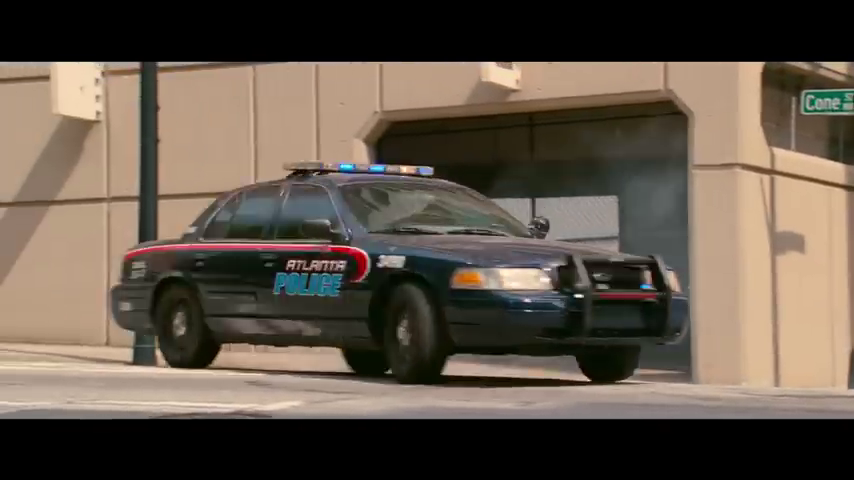

Score: 29.46875, Index: 311


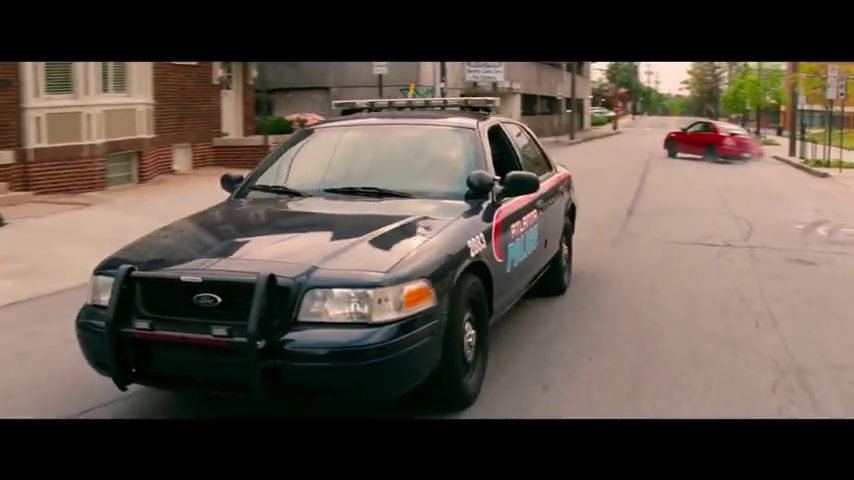

Score: 28.609375, Index: 257


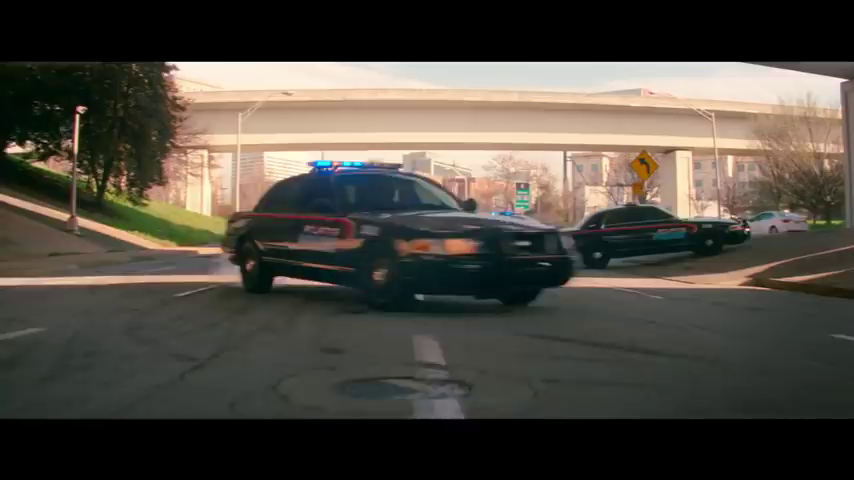

Score: 28.34375, Index: 197


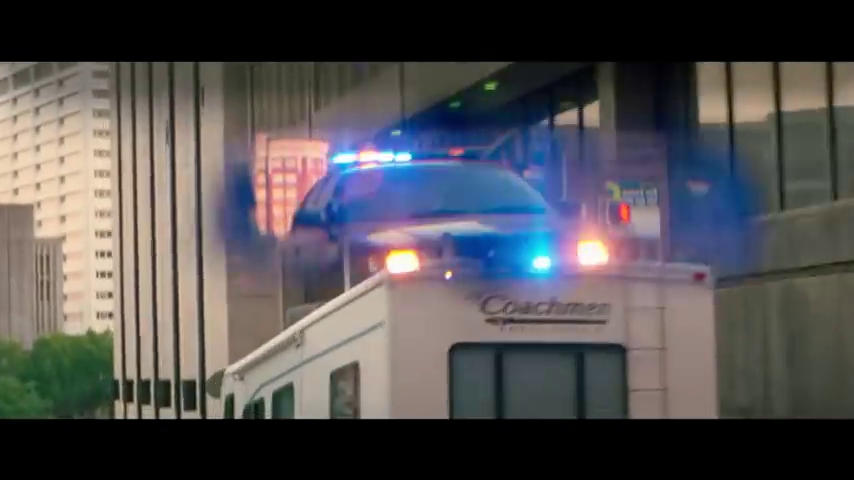

Score: 27.75, Index: 221


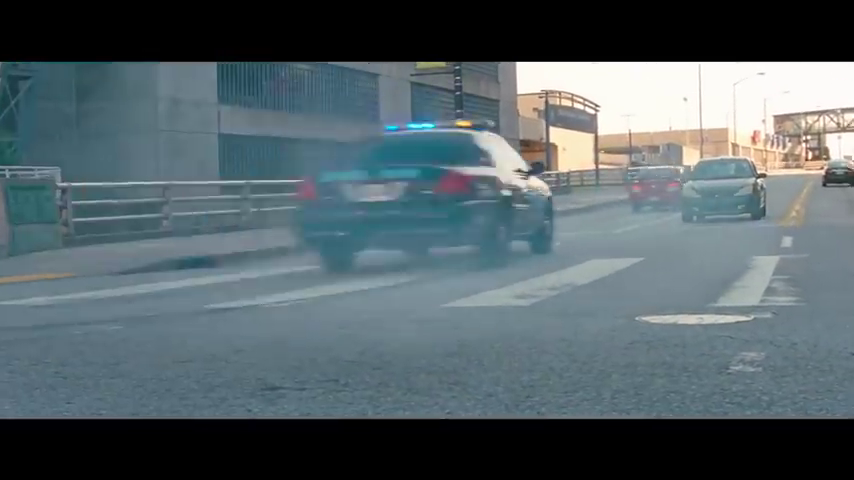

Score: 27.703125, Index: 250


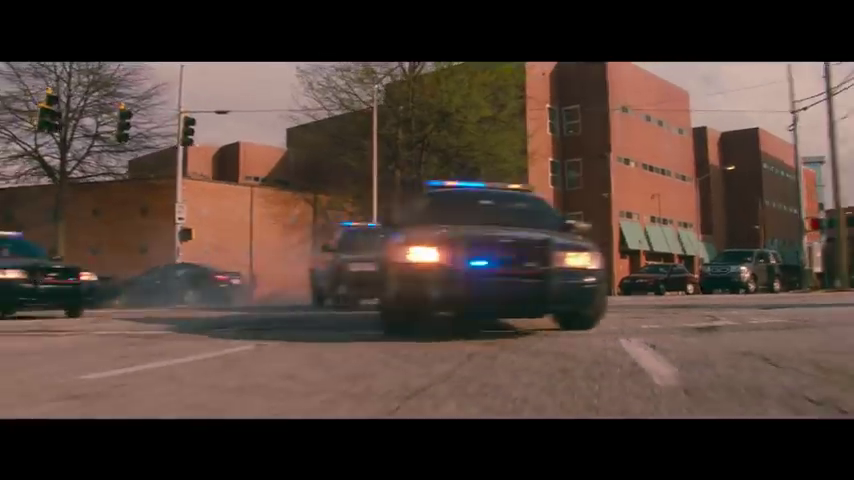

Score: 27.59375, Index: 241


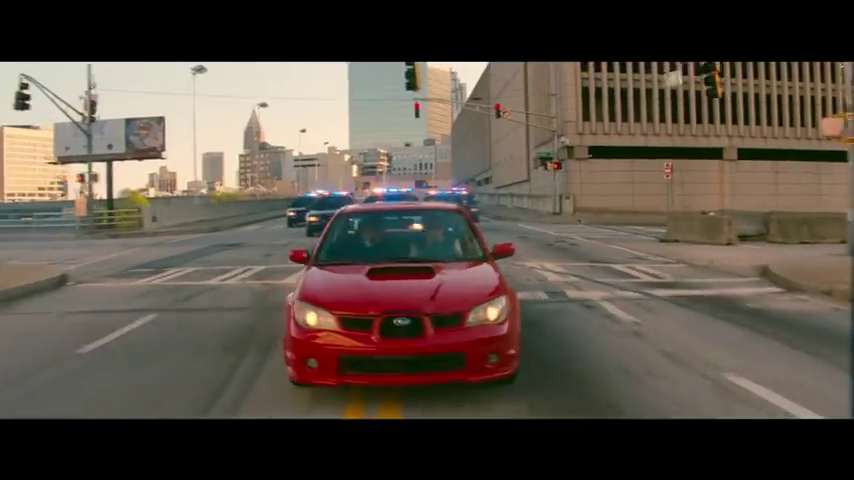

Score: 27.390625, Index: 177


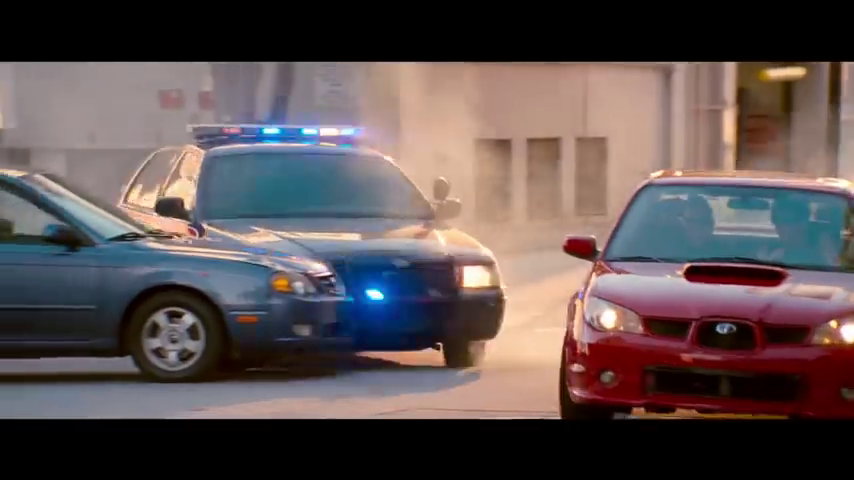

Score: 26.8125, Index: 201


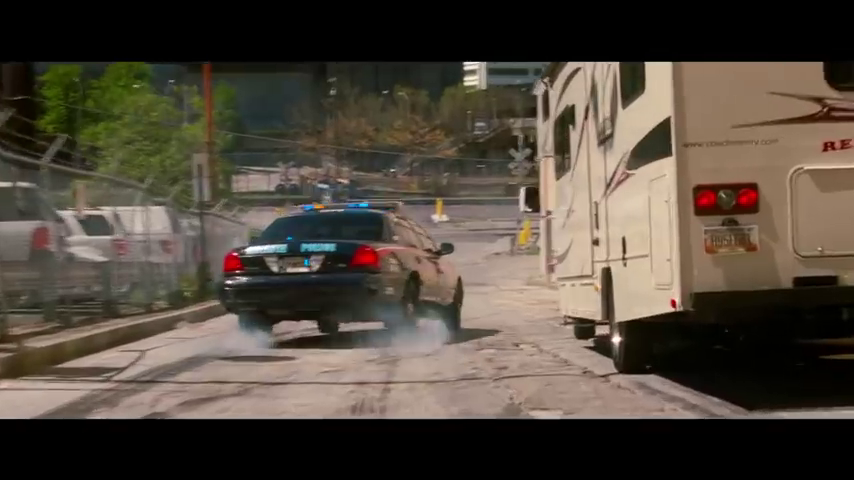

Score: 26.671875, Index: 243


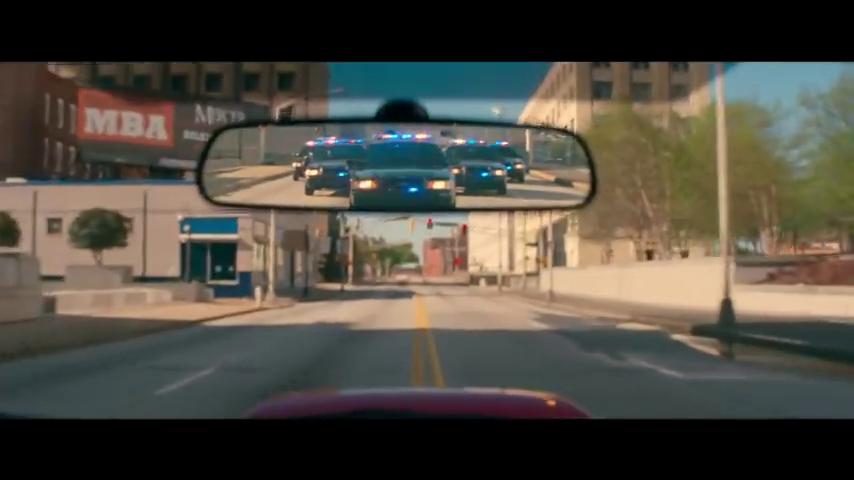

In [67]:
get_frames("police car")